In [13]:
import numpy as np
from sympy import true
import torch
import matplotlib.pyplot as plt
from gp_model import MultiOutputExactGP, MultiOutputSparseGP, MultiOutputStochasticVariationalGP
from dotenv import load_dotenv
import os, time
load_dotenv()
home = os.getenv("MY_WS_HOME")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [14]:
x_data = np.zeros((10000, 2))
x_data[:, 0] = np.random.uniform(0, 1, 10000)
y_data = np.zeros((10000, 1))
# Define a noise standard deviation that varies smoothly with x
# noise_std = 0.2 + 1.0 * np.exp(-((x_data[:, 0] - 0.2) ** 2) / 0.01) + 0.8 * np.exp(-((x_data[:, 0] - 0.35) ** 2) / 0.005)
# noise_std = 0.2 + 0.8 * x_data[:, 0]  # Noise increases with x
noise_std = np.zeros_like(x_data[:, 0])
noise_std[x_data[:, 0] < 0.33] = 0.1
noise_std[(x_data[:, 0] > 0.33) & (x_data[:, 0] < 0.67)] = 0.4
noise_std[x_data[:, 0] > 0.67] = 0.7
y_data[:, 0] = np.sin(2 * np.pi * x_data[:, 0]) + np.random.normal(0, noise_std)

x_test = np.zeros((400, 2))
x_test[:, 0] = np.linspace(0, 1, 400)

X_train = torch.tensor(x_data, dtype=torch.float32).to(device)
Y_train = torch.tensor(y_data, dtype=torch.float32).to(device)

X_test = torch.tensor(x_test, dtype=torch.float32).to(device)

In [15]:
# Standard Multi-Output GP
models = {
    'multioutput': MultiOutputExactGP(
            X_train=X_train,
            Y_train=Y_train,
            device=device
    ),
    'sparse': MultiOutputSparseGP(
            input_dim=X_train.shape[1],
            output_dim=Y_train.shape[1],
            num_latents=Y_train.shape[1],
            independent=True,
            num_inducing_points=128,
            device=device
        ),
    'stochastic_variational': MultiOutputStochasticVariationalGP(
            input_dim=X_train.shape[1],
            output_dim=Y_train.shape[1],
            num_latents=Y_train.shape[1],
            independent=True,
            num_inducing_points=128,
            device=device
        )
    # 'sparse_heteroskedastic': MultiOutputSparseHeteroskedasticGP(
    #         input_dim=X_train.shape[1],
    #         output_dim=Y_train.shape[1],
    #         num_latents=Y_train.shape[1],
    #         num_inducing_points=128,
    #         device=device
    #     )
}

training_times = {}

Initialized ExactMIMOGP with 1 outputs on device cuda
Initialized MultiOutputSparseGP on device cuda
Initialized Stochastic Variational GP on device cuda


In [16]:
for name, model in models.items():
    print(f"Training {name} model...")
    if name == 'multioutput':
        start_time = time.time()
        model.train(X_train, Y_train, training_iter=100, lr=0.1)
        end_time = time.time()
        training_times[name] = end_time - start_time
    else:
        start_time = time.time()
        model.train(X_train, Y_train, num_epochs=100, lr=0.1)
        end_time = time.time()
        training_times[name] = end_time - start_time


Training multioutput model...


Training ExactMIMOGP:   0%|          | 0/100 [00:00<?, ?it/s]/home/x_lab/miniconda3/envs/gp/lib/python3.12/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-06 to the diagonal
  warnings.warn(
Training ExactMIMOGP:  65%|██████▌   | 65/100 [00:03<00:01, 21.03it/s]


Training sparse model...


Training MultiOutputSparseGP: 100%|██████████| 100/100 [00:12<00:00,  8.30it/s]


Training stochastic_variational model...


Training Stochastic Variational GP: 100%|██████████| 100/100 [00:11<00:00,  8.83it/s]


In [17]:
results = {}
prediction_times = {}
for name, model in models.items():
    start_time = time.time()
    Y_pred, Y_std, Y_lower, Y_upper = model.predict(X_test)
    end_time = time.time()
    results[name] = (
        Y_pred.cpu().numpy(),
        Y_std.cpu().numpy(),
        Y_lower.cpu().numpy(),
        Y_upper.cpu().numpy()
    )
    prediction_times[name] = end_time - start_time


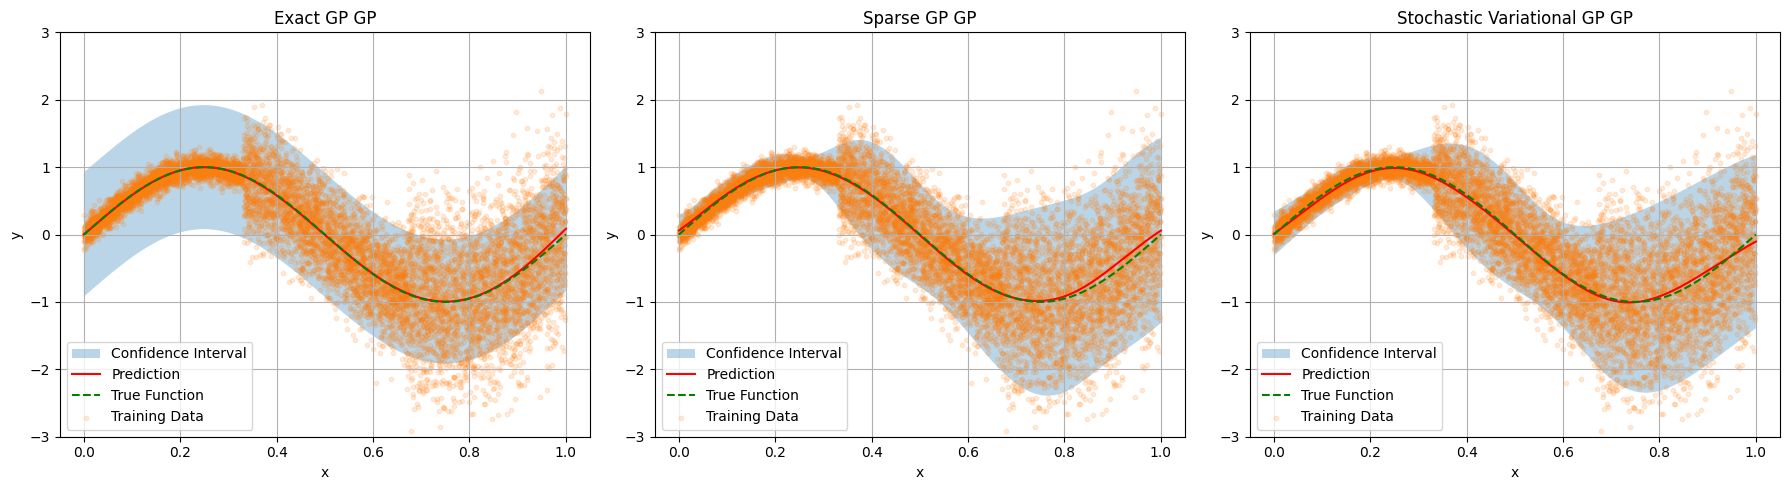

In [18]:
plt.figure(figsize=(18, 5))
plot_name = ["Exact GP",
            "Sparse GP",
            "Stochastic Variational GP"]
for i, (name, (Y_pred, Y_std, Y_lower, Y_upper)) in enumerate(results.items()):
    plt.subplot(1, 3, i + 1)
    plt.title(f"{plot_name[i]} GP")
    plt.fill_between(x_test[:, 0], Y_lower[:, 0], Y_upper[:, 0], alpha=0.3, label='Confidence Interval')
    plt.plot(x_test[:, 0], Y_pred[:, 0], 'r-', label='Prediction')
    plt.plot(x_test[:, 0], np.sin(2 * np.pi * x_test[:, 0]), 'g--', label='True Function')
    plt.scatter(x_data[:, 0], y_data[:, 0], s=10, alpha=0.15, label='Training Data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.ylim(-3, 3)
    plt.legend()
    # print(f"{name} - Mean: {Y_pred.mean():.2f}, Std: {Y_std.mean():.2f}, Lower: {Y_lower.mean():.2f}, Upper: {Y_upper.mean():.2f}")
plt.tight_layout()
plt.savefig(f"{home}src/gp-ws/evaluate_out/simple_gp_validate_compare.png")
plt.show()

In [19]:
# results = {}
# prediction_times = {}
# for name, model in models.items():
#     for i in range(10):
#         _, _, _, _ = model.predict(X_test[i:i+1])
#     start_time = time.time()
#     for i in range(X_test.shape[0]):
#         _, _, _, _ = model.predict(X_test[i:i+1])
#     end_time = time.time()
#     prediction_times[name] = (end_time - start_time) * 1000

# print("Training Times (seconds):")
# for name, time_ in training_times.items():
#     print(f"{name}: {time_:.2f} seconds")

# print("\nPrediction Times (milliseconds):")
# for name, time_ in prediction_times.items():
#     print(f"{name}: {time_:.2f} ms")

1
2


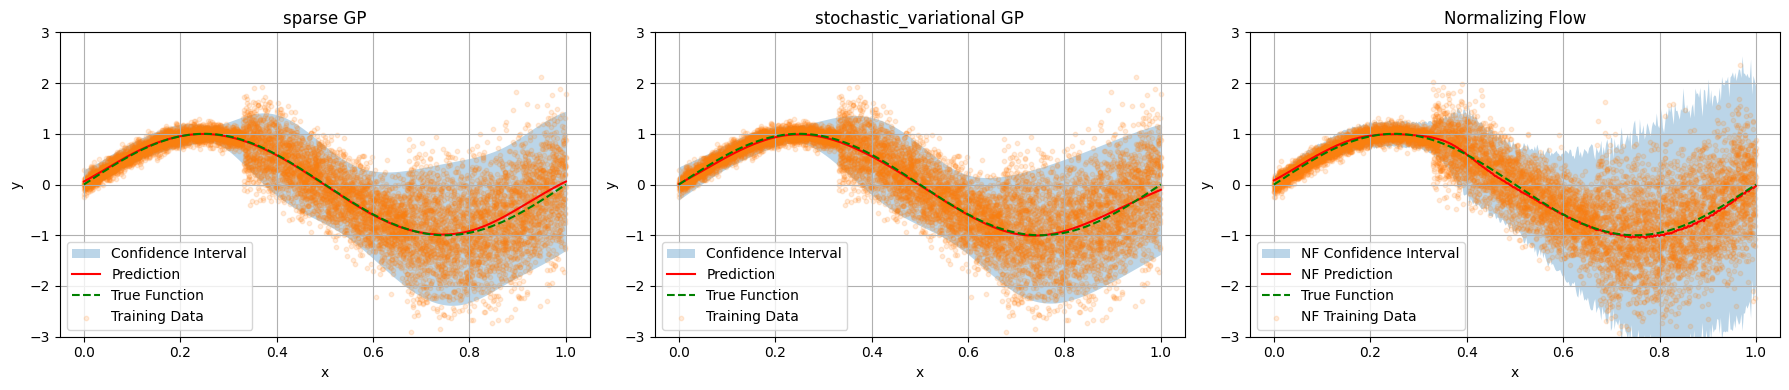

In [25]:
# Load NF data
nf_X_train = np.load('/home/x_lab/workspace/roboracer/src/dyn-estimate-ws/X_train.npy')
nf_Y_train = np.load('/home/x_lab/workspace/roboracer/src/dyn-estimate-ws/Y_train_0.npy')
nf_X_test = np.load('/home/x_lab/workspace/roboracer/src/dyn-estimate-ws/X_test.npy')
nf_samples_mean = np.load('/home/x_lab/workspace/roboracer/src/dyn-estimate-ws/samples_mean.npy')
nf_samples_std = np.load('/home/x_lab/workspace/roboracer/src/dyn-estimate-ws/samples_std.npy')

# Create figure with 3 subplots
plt.figure(figsize=(18, 4))

# Plot GP models (assume you have 2 of them)
for i, (name, (Y_pred, Y_std, Y_lower, Y_upper)) in enumerate(results.items()):
    if i == 0:
        continue
    plt.subplot(1, 3, i)
    plt.title(f"{name} GP")
    plt.fill_between(x_test[:, 0], Y_lower[:, 0], Y_upper[:, 0], alpha=0.3, label='Confidence Interval')
    plt.plot(x_test[:, 0], Y_pred[:, 0], 'r-', label='Prediction')
    plt.plot(x_test[:, 0], np.sin(2 * np.pi * x_test[:, 0]), 'g--', label='True Function')
    plt.scatter(x_data[:, 0], y_data[:, 0], s=10, alpha=0.15, label='Training Data')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid()
    plt.ylim(-3, 3)
    plt.legend()
    print(i)

# Plot NF results in third subplot
plt.subplot(1, 3, 3)
plt.title("Normalizing Flow")
plt.fill_between(nf_X_test[:, 0],
                 nf_samples_mean[:, 0] - 20 * nf_samples_std[:, 0],
                 nf_samples_mean[:, 0] + 20 * nf_samples_std[:, 0],
                 alpha=0.3, label='NF Confidence Interval')
plt.plot(nf_X_test[:, 0], nf_samples_mean[:, 0], 'r-', label='NF Prediction')
plt.plot(nf_X_test[:, 0], np.sin(2 * np.pi * nf_X_test[:, 0]), 'g--', label='True Function')
plt.scatter(nf_X_train[:, 0], nf_Y_train[:, 0], s=10, alpha=0.15, label='NF Training Data')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.ylim(-3, 3)
plt.legend()

# Final display
plt.tight_layout()
plt.show()